# CSE519 Project: Dating Documents
## Tim Zhang (110746199)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from bs4 import BeautifulSoup

# Global settings
%matplotlib notebook
pd.set_option('display.max_rows', None)  

# Exploratory Analysis

## Corpus of Historical American English (COHA)
### Parsing

We will need to parse the COHA corpus into date labels and text.  The corpus is subdivided by sources as Fiction, Magazine, News, and Nonfiction.  It may prove useful to keep the categories of data sources disjoint.

The data files have an easily parsable format, where newlines delimit the examples $(x^{(i)}, y^{(i)})$ and the label is delimited with a tab.  We will store the data as a Pandas dataframe.

In [2]:
def parse_coha(filename):
    data = []
    
    with open('Data/COHA/' + filename, 'r') as f:
        samples = f.read().split('\n')[:-1]  # Ignore final newline
    
    for sample in samples:
        split = sample.split('\t')
        data.append((split[0], split[1]))

    # Save data into dataframe
    df = pd.DataFrame(data, columns=['Year', 'Text']).sort_values(['Year'])
    
    # Create Decade label
    df['Decade'] = df.apply(lambda row: int(str(row.Year)[:3] + '0'), axis=1)
    
    return df

Now we can parse each of the COHA categories into a dictionary.

In [3]:
sources = ['coha_fiction', 'coha_mag', 'coha_news', 'coha_nf']
coha_data = dict.fromkeys(sources, pd.DataFrame)

for source in sources:
    coha_data[source] = parse_coha(source + '.data')

Next we will concatenate each dataframe into the full dataset and add a new column for the length of the text.

In [40]:
coha_full = coha_data['coha_mag'].append(coha_data['coha_news']).append(coha_data['coha_fiction']).append(coha_data['coha_nf'])
coha_full.sort_values(['Year'], inplace=True)
coha_full.reset_index(drop=True, inplace=True)
coha_full['Length'] = coha_full.apply(lambda row: len(row.Text.split()), axis=1)

Finally, we will save the dataframe as a pkl object.

In [59]:
coha_full.to_pickle('coha_full.pkl')

In [2]:
coha_full = pd.read_pickle('coha_full.pkl')

### Analysis

Once we have our data parsed into dataframes, we should do some exploratory analysis.  For this we will investigate summary statistics of the full dataset at the year and decade resolutions with respect to the occurances of the labels.  Since there are almost 200 years represented in the dataset, we will output this data raw.

In [3]:
def analyze_coverage(counts):
    # Print summary statistics on coverage data
    print("    Max: %s" % (counts.max()))
    print("    Min: %s" % (counts.min()))
    print("    Mean: %s" % (counts.mean()))
    print("    Std: %s" % (counts.std()))
    print("    Median: %s" % (counts.median()))

In [10]:
def analyze_coha_data(df):
    # Get year coverage data
    counts = pd.value_counts(df['Year']).sort_index()
    
    print "Year Coverage Statistics:"
    analyze_coverage(counts)

    print '\nComplete Year Distribution:'
    print counts.head(-1)
    print '\n'
    
    # Get decade coverate data
    decade_counts = pd.value_counts(df['Decade']).sort_index()
    print "Decade Coverage Statistics:"
    analyze_coverage(decade_counts)

    plt.figure()
    decade_counts.sort_index().plot(kind='barh', title="Number of Documents per Decade")
    print '\n'

Year Coverage Statistics:
    Max: 1278
    Min: 1
    Mean: 200.0
    Std: 212.749740919
    Median: 130.0

Complete Year Distribution:
1810       2
1811       4
1812       6
1813       1
1814       3
1815      11
1816       8
1817       9
1818       5
1819       7
1820      14
1821      20
1822      21
1823      21
1824      16
1825      13
1826      16
1827      39
1828      27
1829      37
1830      40
1831      25
1832      44
1833      55
1834      50
1835      67
1836      63
1837      44
1838      39
1839      60
1840      30
1841      30
1842      34
1843      45
1844      76
1845      69
1846      45
1847      58
1848      52
1849      65
1850      40
1851      41
1852      44
1853      55
1854      43
1855      61
1856      45
1857      35
1858      18
1859      48
1860      30
1861      45
1862      56
1863      54
1864      90
1865      49
1866      47
1867      41
1868      76
1869      68
1870      39
1871      75
1872      59
1873      76
1874      89
1875      94
1876 

<IPython.core.display.Javascript object>


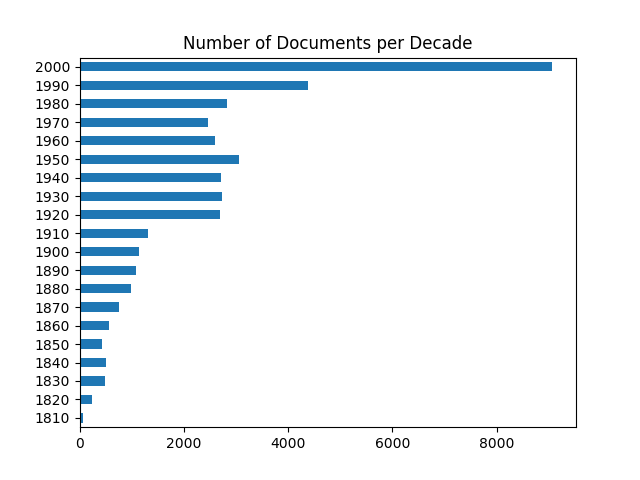

In [11]:
analyze_coha_data(coha_full)

From the above analysis we see that the COHA dataset is not balanced with respect to year (or decade) representation.  As mentioned in my preliminary report, we should try to balance our classes for the best results.  As such we will need our other data sources to try and fill in the gaps.

Next let us investigate the size of the datasets (in tokens) at decade resolution.

In [12]:
def analyze_text(df):
    decades = df.groupby('Decade')['Length']
    print 'Text Frequency Statistics:'
    print("\nTotal:\n%s" % (decades.sum()))
    print("\nMax:\n%s" % (decades.max()))
    print("\nMin:\n%s" % (decades.min()))
    print("\nMean:\n%s" % (decades.mean()))
    print("\nStd:\n%s" % (decades.std()))
    print("\nMedian:\n%s" % (decades.median()))
    plt.figure()
    decades.sum().plot(kind='barh', title="Total Token Count per Decade")

Text Frequency Statistics:

Total:
Decade
1810     2866316
1820     9496850
1830    21853319
1840    23512631
1850    24376172
1860    19617488
1870    24253002
1880    25419490
1890    24617174
1900    26362711
1910    28253093
1920    25997854
1930    26737154
1940    25890449
1950    27062006
1960    25365215
1970    26211245
1980    30264682
1990    29758832
2000    30458993
Name: Length, dtype: int64

Max:
Decade
1810    227155
1820    160380
1830    252998
1840    364780
1850    251887
1860    255796
1870    213229
1880    191478
1890    200410
1900    240932
1910    210337
1920    213193
1930    245479
1940    213128
1950    207824
1960    176500
1970    302613
1980    294180
1990    141824
2000     60408
Name: Length, dtype: int64

Min:
Decade
1810    216
1820    197
1830    180
1840      1
1850      0
1860    188
1870      1
1880    152
1890     58
1900    149
1910    145
1920     43
1930     66
1940     33
1950     61
1960     60
1970     28
1980     14
1990      7
2000      

<IPython.core.display.Javascript object>


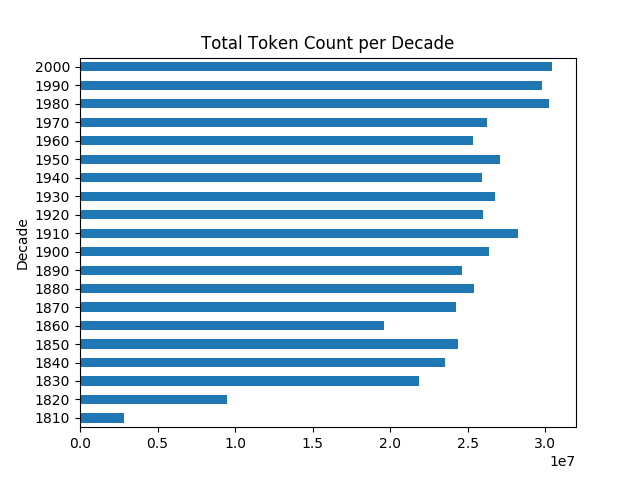

In [13]:
analyze_text(coha_full)

We can see that the amount of tokens per decade is relatively balanced.  This implies that while there are less documents for the earlier decades, each document has more text.  The summary statistics also indicate that this is the case.